# Regioned Flasher

The regioned flasher breaks up the temperature-density plane into multiple region. In each region, a K-D tree is constructed for points distributed within the region in T-D coordinates (because they are the coordinates of the EOS and require no iteration to obtain them). Thus distributing the points cannot fail (like iterative calculations in P-H coordinates might). To start, lets begin with a rectangular region in the supercritical region as a demonstration. The real regions are much more complex as they need to handle the complete fluid domain, deal with solid-liquid phase equilibria, etc..

In [1]:
import timeit, json

import teqpflsh, teqp 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = "n-Propane"

path = f'{teqp.get_datapath()}/dev/fluids/{name}.json'
jresid = {"kind": "multifluid", "model": {"components": [name], "root": teqp.get_datapath()}}
jidealgas = {"kind": "IdealHelmholtz", "model": [teqp.convert_CoolProp_idealgas(path, 0)]}

rf = teqpflsh.RegionedFlasher(
    ideal_gas=json.dumps(jidealgas), 
    resid=json.dumps(jresid), 
    mole_fractions=np.array([1.0])
)
# To start off there are no regions in the regioned flasher
print('# of regions:', len(rf.get_regions_rw()))

# Now we make a region with rectangular shape in T, rho coordinates
# As we will see, a rectangular shape with only the corners defined doesn't work so well when transformed into 
# other coordinates
Tmin = 400 # K
Tmax = 450 # K
rhomin = 1e-6 # mol/m³
rhomax = 6000 # mol/m³
Tpoly = np.array([Tmin, Tmin, Tmax, Tmax, Tmin])
rhopoly = np.array([rhomin, rhomax, rhomax, rhomin, rhomin])
NT = 1000
Nrho = 1000

rf.add_region(T=Tpoly, rho=rhopoly, NT=NT, Nrho=Nrho)
print('# of regions:', len(rf.get_regions_ro()))

# of regions: 0
# of regions: 1


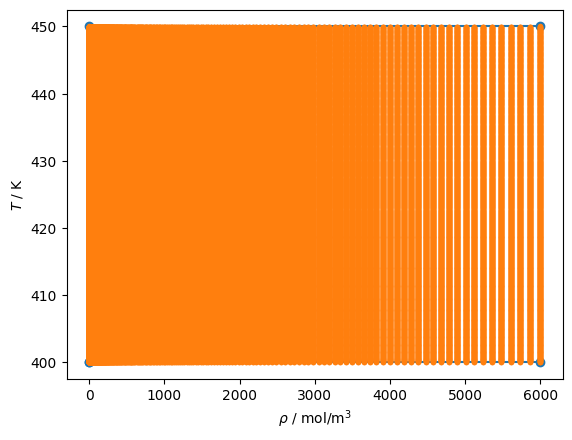

In [3]:
# Here is the bounding region and the points used for construction of the K-D tree
# This all looks nice
for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.DT, Nsplit=5)
    
    pset = reg.propset_bounding
    plt.plot(pset.rho, pset.T, 'o-')

    pset = reg.propset_Trhogrid
    plt.plot(pset.rho, pset.T, '.')
plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel='$T$ / K');

But when you shift to another variable pair, here density and entropy, the rectangular box and its sampled (in $T$, $\rho$) points do not all map together

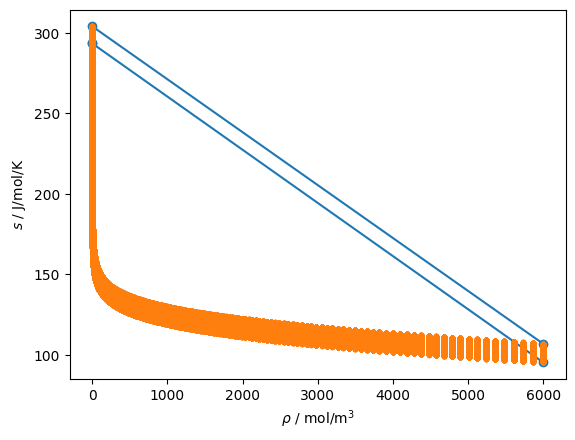

In [4]:
for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.DS, Nsplit=5)
    
    pset = reg.propset_bounding
    plt.plot(pset.rho, pset.s, 'o-')

    pset = reg.propset_Trhogrid
    plt.plot(pset.rho, pset.s, '.')
plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel='$s$ / J/mol/K');

In order to get around this problem, the box needs to be sampled at more than 5 points

Exercise for reader: build a more dense polygon defining the boundary of the box, with many more points along each side

To better understand the timing of each step, it can be useful to profile each step independently. The ``_many`` methods has been written for this purpose. The overhead in nanobind with pre-allocated buffers being passed to the function is functionally zero.

In [5]:
N = 500000

for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.DP, Nsplit=5)
    
    tree = reg.get_kdtree(teqpflsh.PropertyPairs.DP)    
    X = np.linspace(2000, 2001, N)
    Y = np.linspace(0.25e7, 0.251e7, N)
    idx = np.zeros_like(X, dtype=int)
    d2 = np.zeros_like(Y)
    tic = timeit.default_timer()
    tree.get_nearest_indexd2_many(X, Y, idx, d2)
    toc = timeit.default_timer()
    print((toc-tic)/N*1e6, 'μs to look up a point from the K-D tree')
    print(f'The K-D tree consumes', tree.get_used_bytes()/1024**2, "MiB")

    TT = np.zeros_like(X)
    DD = np.zeros_like(X)
    tic = timeit.default_timer()
    reg.get_starting_Trho_many(teqpflsh.PropertyPairs.DP, X, Y, TT, DD, d2)
    toc = timeit.default_timer()
    print((toc-tic)/N*1e6, 'μs to look up a point from the K-D tree and return the (T, rho) point and its '
          'distance. This should be a smidge slower than the above calculation')

0.19432550005149096 μs to look up a point from the K-D tree
The K-D tree consumes 32.41525650024414 MiB
0.1970805840101093 μs to look up a point from the K-D tree and return the (T, rho) point and its distance. This should be a smidge slower than the above calculation


Putting it all together, here is an example of using the entire flash calculation. The steps are:
1. Find the nearest point in the K-D tree to get a starting value for $T$ and $\rho$ for further iteration
2. Do the iteration to find the right $T$, $\rho$ satisfying the problem statement (trivial in this case because $T$, $\rho$ are input variables)

In [6]:
for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.DT, Nsplit=5)
N = 50000
X = np.linspace(2000, 2001, N)
Y = np.linspace(250, 251, N)
TT = np.zeros_like(X)
DD = np.zeros_like(X)
steps = np.zeros_like(X, dtype=int)
maxabsr = np.zeros_like(Y)
newtontime = np.zeros_like(Y)
candtime = np.zeros_like(Y)
tic = timeit.default_timer()
rf.flash_many(teqpflsh.PropertyPairs.DT, X, Y, TT, DD, steps, maxabsr, newtontime, candtime)
toc = timeit.default_timer()
print((toc-tic)/N*1e6, np.mean(newtontime), np.mean(candtime), np.mean(steps))

1.3062583201099187 0.9456310399999999 0.25357912 0.0


The timing is carried out at a fairly granular level. The ``candtime`` argument is the time required (in μs) to do preparation of the candidates from the K-D tree values. The ``newtontime`` is the time spent (in μs) preparing the iteration object and actually doing the iteration. In this case the inputs do not require any iteration, but the newton iterator is still constructed.

In [7]:
# Here we iterate for two variables, it is much slower
for reg in rf.get_regions_rw():
    reg.add_pair(proppair=teqpflsh.PropertyPairs.PS, Nsplit=5)
    
# Take the points in the K-D tree to do calculations
# They trivially satisfy the stopping conditions!
propset = reg.propset_Trhogrid
X = propset.p
Y = propset.s
o = rf.flash(teqpflsh.PropertyPairs.PS, X[0], Y[0])
print(o.T, o.rho, o.candidate_duration_us, o.total_duration_us, o.newton_duration_us, o.step_count)

400.04716315487264 1.0000000000000004e-06 5.041 16.0 10.834 1


In [8]:
# Now p, s inputs but with a bit of noise in entropy to force the 
# Newton iterator to actually do something

# Input variables
X = propset.p
Y = propset.s + np.random.random(X.shape)

# Output buffers
TT = np.zeros_like(X)
DD = np.zeros_like(X)
steps = np.zeros_like(X)
maxabsr = np.zeros_like(Y)
newtontime = np.zeros_like(Y)
candtime = np.zeros_like(Y)
tic = timeit.default_timer()

rf.flash_many(teqpflsh.PropertyPairs.PS, X, Y, TT, DD, steps, maxabsr, newtontime, candtime)
toc = timeit.default_timer()
print((toc-tic)/len(X)*1e6, np.mean(newtontime), np.mean(candtime), np.mean(steps), np.mean(maxabsr), np.sum(TT<0))

3.2074755386728637 2.643995782586261 0.46512329597547125 3.0077775161447087 1.4765034340778192e-10 0


Ok, that's good. Iteration was carried out, and the deviations between the specified and iterated entropy and pressure were good. It took approximately 1.1 μs per iteration step of the Newton iterator, which isn't too bad, but we did start not too far from the actual solution.